# Plots for cluster 
Compare Deepseek R1 and V3 (our prompts, long and short), compared with GPT4 accuracy

In [1]:
import os
import json
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

In [2]:
from plot import *

In [3]:
def load_ndjson(file):
    output = []
    with open(file, "r") as f:  
        for line in f:
            line = line.strip()  
            if line:  
                try:
                    single_cell = json.loads(line)
                    output.append(single_cell)
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from line: {e}")
    return output

In [4]:
# load results
file_paths = [
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/r1_short/results.csv',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/r1_long/results.csv',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/v3_short/results.csv',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/v3_long/results.csv',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/gpt4o_2025Mar27/results_cleaned/results.csv',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts_original/r1/results.csv'
]
r1, r1_long, v3, v3_long, GPT4, r1_original = (pd.read_csv(file) for file in file_paths)


In [5]:
# get metrics
groups = ['R1 Long Reasoning', 'R1', 'V3-0324 Long Reasoning', 'V3-0324', 'GPT-4o-0326']
accuracies = [float(df.iloc[-1,2]) for df in [r1_long, r1, v3_long, v3, GPT4]]

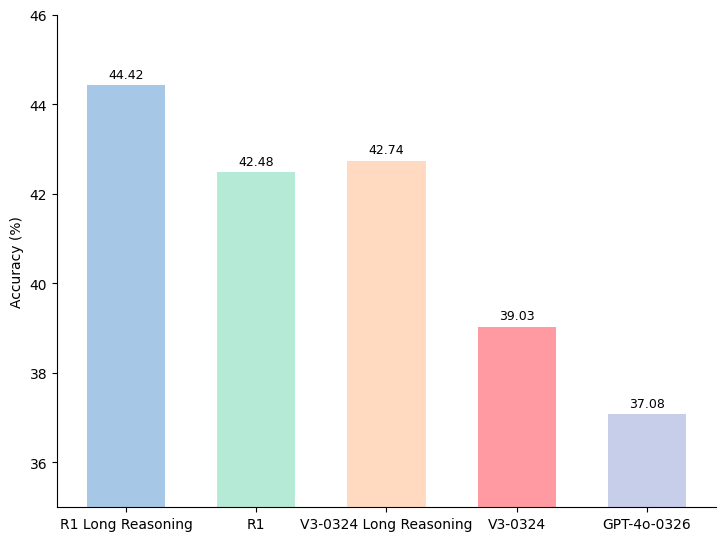

In [12]:
plotter = MetricPlotter(bar_width = 0.6, annotation_digits=2, y_lim_lower = 35, y_lim_upper=46)
plotter.group_gap = 0
plotter.text_margin = 0.001
plotter.display_axes_borders='xy'
plotter.colors = ['#A7C7E7', '#B5EAD7', '#FFDAC1', '#FF9AA2', '#C7CEEA']
# plotter.rotation = 30
plotter.barplot(groups ,np.array(accuracies), 
             x_label="", y_label="Accuracy", 
             # title="LLMs' Performance for Clusters"
             )

In [6]:
response_paths = [
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/r1_short/responses.ndjson',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/r1_long/responses_long.ndjson',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/v3_short/responses.ndjson',
    '/cristealab/xiwang/DSR1_Preprint/Outputs/GPT4Paper_Clusters/responses/prompts/v3_long/responses_long.ndjson'
]
response_r1, response_r1_long, response_v3, response_v3_long = (load_ndjson(file) for file in response_paths)


In [7]:
tokens = [(np.mean([r['reasoning_token'] for r in response_r1_long]), np.mean([r['completion_token'] for r in response_r1_long])), 
             (np.mean([r['reasoning_token'] for r in response_r1]), np.mean([r['completion_token'] for r in response_r1])),
             np.mean([r['completion_token'] for r in response_v3_long]),
             np.mean([r['completion_token'] for r in response_v3])
]

In [17]:
response_v3_long[0].keys()

dict_keys(['index', 'cell_type_ground_truth', 'prompt', 'response', 'prompt_token', 'completion_token'])

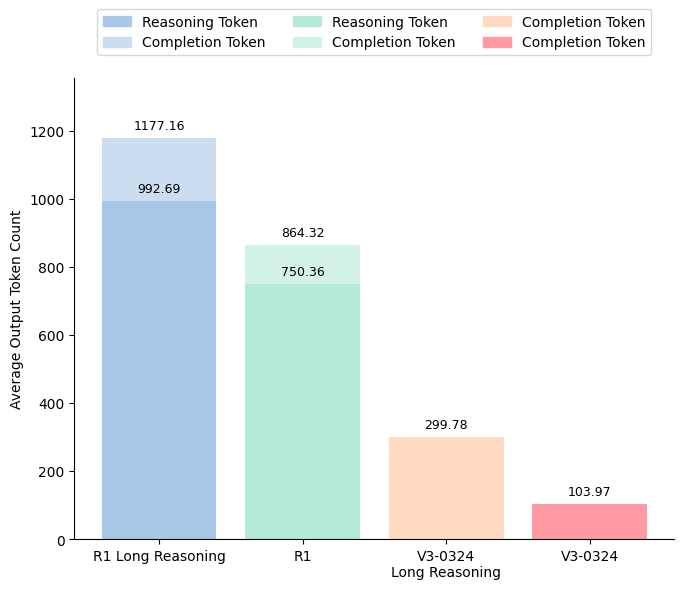

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # Still needed for handles
import numpy as np
from typing import List, Union, Tuple, Optional

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.

    Args:
        color: An matplotlib-compatible color string (e.g., 'red', '#FF0000', (1, 0, 0)).
        amount: The factor to lighten by. 0 means no change, 1 means white.

    Returns:
        A lightened color in RGB tuple format.
    """
    try:
        c = mcolors.to_rgb(color)
        c_white = mcolors.to_rgb('white')
        # Linear interpolation towards white
        return tuple(c_val + (white_val - c_val) * amount for c_val, white_val in zip(c, c_white))
    except ValueError:
        print(f"Warning: Could not parse color '{color}'. Using gray.")
        try:
            c_gray = mcolors.to_rgb('gray')
            c_white = mcolors.to_rgb('white')
            return tuple(c_val + (white_val - c_val) * amount for c_val, white_val in zip(c_gray, c_white))
        except ValueError:
            return (0.7, 0.7, 0.7) # Absolute fallback

def plot_model_performance(
    model_names: List[str],
    scores: List[Union[float, Tuple[float, float]]],
    colors: Optional[List[str]] = None,
    title: str = "Model Performance Comparison",
    ylabel: str = "Score",
    display_border: bool = True,
    lighten_factor: float = 0.4,
    figsize: Tuple[int, int] = (10, 6),
    text_offset_factor: float = 0.015,
    # --- Labels for legend ---
    # Tuple for dual scores (base, incremental), String for single score
    legend_labels: Union[Tuple[str, str], str] = ('Base', 'Incremental'),
    single_score_label_override: Optional[str] = None # New: Specify label for single scores explicitly
):
    """
    Generates a bar plot comparing model performance, creating explicit legend
    entries for each bar component.

    Args:
        model_names: A list of strings representing the names of the models.
        scores: A list containing the performance scores. Each element can be:
                - A single float (for models with one score).
                - A tuple of two floats (low, high) for models with a range.
        colors: An optional list of matplotlib-compatible color strings for each bar.
                If None, default colors will be used. Must match the length of model_names.
        title: The title of the plot.
        ylabel: The label for the y-axis.
        display_border: If False, hides the top and right plot borders (spines).
                        If True (default), shows all borders.
        lighten_factor: The factor used to lighten the color for the 'high' part
                        of the bar when two scores are given (0=no lighten, 1=white).
        figsize: The size of the figure (width, height) in inches.
        text_offset_factor: A factor (relative to max score) to offset text labels
                            vertically above the bars for better readability.
        legend_labels: Describes the legend text.
                       - If a tuple (e.g., ('Reasoning', 'Completion')), the first
                         string labels the base part of dual scores, the second labels
                         the incremental part.
                       - If a string (e.g., 'Score'), it labels single-score bars.
                         If dual scores exist, the second label from the default
                         ('Base', 'Incremental') or a sensible guess might be used
                         for the incremental part unless overridden.
        single_score_label_override: Explicitly set the legend label for single-score
                                     bars. If None, uses the rules described for
                                     `legend_labels`. Useful when single scores represent
                                     the same concept as the *incremental* part of dual scores.
    """
    num_models = len(model_names)
    if len(scores) != num_models:
        raise ValueError("Length of 'model_names' and 'scores' must be the same.")

    if colors is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        default_colors = prop_cycle.by_key()['color']
        colors = [default_colors[i % len(default_colors)] for i in range(num_models)]
    elif len(colors) != num_models:
        raise ValueError("Length of 'colors' must match 'model_names' if provided.")

    # Determine legend labels based on input
    if isinstance(legend_labels, tuple) and len(legend_labels) == 2:
        base_label, incremental_label = legend_labels
        single_label = single_score_label_override if single_score_label_override is not None else incremental_label # Default single to incremental if override not set
    elif isinstance(legend_labels, str):
        base_label = "Base" # Default if only single label provided
        incremental_label = "Incremental" # Default if only single label provided
        single_label = single_score_label_override if single_score_label_override is not None else legend_labels
    else:
        raise ValueError("legend_labels must be a tuple of two strings or a single string.")


    x_pos = np.arange(num_models)
    max_score = 0
    legend_handles = [] # List to store patch handles for the legend
    legend_texts = [] # List to store text labels for the legend

    plt.figure(figsize=figsize)
    ax = plt.gca()

    for i in range(num_models):
        score = scores[i]
        color = colors[i]

        # Determine max_score for plot limits and text offset
        current_max = 0
        if isinstance(score, (tuple, list)):
             current_max = score[1] if len(score) > 1 else (score[0] if len(score) > 0 else 0)
        else:
             current_max = score
        # Ensure current_max is a number before comparison
        if isinstance(current_max, (int, float)) and current_max > max_score:
             max_score = current_max

        text_offset = max_score * text_offset_factor if max_score > 0 else 0.01

        if isinstance(score, (tuple, list)) and len(score) == 2:
            low_score, high_score = score
            if low_score > high_score:
                 print(f"Warning: Model '{model_names[i]}', low score ({low_score}) > high score ({high_score}). Swapping.")
                 low_score, high_score = high_score, low_score

            if low_score < 0 or high_score < 0:
                print(f"Warning: Model '{model_names[i]}' has negative scores.")

            # Plot base bar - NO automatic label
            bar1 = ax.bar(x_pos[i], low_score, color=color)
            # Add handle and label for legend manually
            legend_handles.append(mpatches.Patch(color=color))
            legend_texts.append(base_label)

            # Plot incremental bar - NO automatic label
            if high_score > low_score:
                lighter_c = lighten_color(color, amount=lighten_factor)
                bar2 = ax.bar(x_pos[i], high_score - low_score, bottom=low_score, color=lighter_c)
                # Add handle and label for legend manually
                legend_handles.append(mpatches.Patch(color=lighter_c))
                legend_texts.append(incremental_label)

            # Add text labels for scores
            if low_score > 0:
                ax.text(x_pos[i], low_score + text_offset, f"{low_score:.2f}", ha='center', va='bottom', fontsize=9)
            ax.text(x_pos[i], high_score + text_offset, f"{high_score:.2f}", ha='center', va='bottom', fontsize=9)

        else:
            # Single score provided
            single_score = float(score)
            if single_score < 0:
                 print(f"Warning: Model '{model_names[i]}' has negative score.")

            # Plot single bar - NO automatic label
            bar_single = ax.bar(x_pos[i], single_score, color=color)
            # Add handle and label for legend manually
            legend_handles.append(mpatches.Patch(color=color))
            legend_texts.append(single_label)

            # Add text label
            ax.text(x_pos[i], single_score + text_offset, f"{single_score:.2f}", ha='center', va='bottom', fontsize=9)

    # --- Plot Customization ---
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=0)

    ax.set_ylim(bottom=0, top=max_score * 1.15)

    if not display_border:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # --- Add Explicit Legend ---
    if legend_handles: # Only add legend if there's something to show
        ax.legend(handles=legend_handles, labels=legend_texts,
                  bbox_to_anchor=(0.5, 1.05),  # 将图例放在轴的上方中央
              loc='lower center',         # 将图例的下边缘中心与 bbox_to_anchor 对齐
              borderaxespad=0.,
              ncol=3)

    # Optional grid
    # ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_model_performance(
    model_names=['R1 Long Reasoning', 'R1', 'V3-0324\nLong Reasoning', 'V3-0324'],
    scores=tokens,
    colors=['#A7C7E7', '#B5EAD7', '#FFDAC1', '#FF9AA2'],
    title="",
    ylabel="Average Output Token Count",
    figsize=(7, 6),
    display_border=False,
    # Provide the two labels for dual scores
    legend_labels=('Reasoning Token', 'Completion Token'),
    # Explicitly state that single scores also represent 'Completion Token'
    single_score_label_override='Completion Token'
)